0) **Imports**

In [4]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np

1) **Consititutive behaviour Definition**

Strain Energy
$$
\psi(\varepsilon(u)) = \frac{\lambda}{2}
( tr {\varepsilon}^2 + \frac{\alpha}{2} tr {\varepsilon}^4) + 
\mu ( |\varepsilon|^2  + \frac{\alpha}{2} |\varepsilon|^4).
$$

In [5]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
nu = 0.3 
E = 100.0 
alpha = 0.0
lamb, mu = youngPoisson2lame(nu, E)

# alpha : Equivalent to sig = lamb*df.div(u)*df.Identity(2) + mu*(df.grad(u) + df.grad(u).T)
def psi_e(e):
    tr_e = df.tr(e)
    e2 = df.inner(e,e)
    
    return (0.5*lamb*(tr_e**2 + 0.5*alpha*tr_e**4) +
           mu*(e2 + 0.5*alpha*e2**2))

psi = lambda w: psi_e(0.5*(df.grad(w) + df.grad(w).T))

2) **Mesh**  

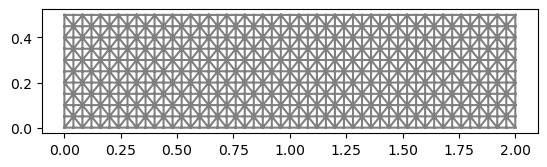

In [6]:
Nx =  50 
Ny =  10 
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** 

In [7]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces**

In [8]:
Uh = df.VectorFunctionSpace(mesh, "CG", 1) # Equivalent to CG
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag)

5. **Variational Formulation**: Minimisation 
\begin{align} 
\min_{u \in U} \left ( J(u):=\int_{\Omega} \psi(u) dx - \Pi_{ext}(u) \right) \\
F(u; v) = \delta J(u;v) = 0 \quad \forall v \in V , \\
\delta F(u, du; v) = \delta^2 J(u, du;v) \quad \forall v \in V ,
\end{align} 
<br>


In [9]:
du = df.TrialFunction(Uh)            # Incremental displacement
v  = df.TestFunction(Uh)             # Test function
uh  = df.Function(Uh)                 # Displacement from previous iteration

ty = -0.1
traction = df.Constant((0.0, ty))

P_ext = df.inner(traction,uh)*ds(loadBndFlag)
P_int = psi(uh)*dx

J = P_int - P_ext

F = df.derivative(J, uh, v)
DF = df.derivative(F, uh, du) # Optional


6) **Solving**

In [11]:
# Compute solution
start = timer()
df.solve(F == 0, uh, bcL, J = DF)
end = timer()

print("Time spent: ", end - start)
print("Norm L2: ", df.assemble(df.inner(uh,uh)*dx))

assert np.allclose(df.assemble(df.inner(uh,uh)*dx), 0.0034646449803129205) # test for Nx = 50, Ny = 10

Time spent: Solving nonlinear variational problem.
 0.0012823369997931877
Norm L2:  0.0034646449803129205
  Newton iteration 0: r (abs) = 5.942e-14 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


7. **Pos-Processing**

In [12]:
import fetricks.fenics.postprocessing.wrapper_io as iofe

def sigma_law(w):    
    e = 0.5*(df.grad(w) + df.grad(w).T) 
    e = df.variable(e)
    return df.diff(psi_e(e),e)

Sh = df.VectorFunctionSpace(mesh, "DG", 0, dim = 3) 
epsh = df.project( df.as_vector([uh[0].dx(0), uh[1].dx(1), np.sqrt(2)*uh[0].dx(1)]) , Sh)
sig = sigma_law(uh)
sigh = df.project( df.as_vector([sig[0,0], sig[1,1], np.sqrt(2)*sig[0,1]]), Sh)

uh.rename("u",'')
epsh.rename("eps",'')
sigh.rename("sig",'')

iofe.exportXDMF_gen("bar_nonlinear_vtk.xdmf", fields={'vertex': [uh], 'cell_vector': [epsh, sigh] })
iofe.exportXDMF_checkpoint_gen("bar_nonlinear_sol.xdmf", fields={'vertex': [uh], 'cell': [epsh, sigh]})

8. **Export reference database**

In [33]:
from ddfenics.dd.ddfunction import DDFunction
from fetricks import symgrad_mandel, tensor2mandel

Sh0 = df.VectorFunctionSpace(mesh, 'DG', degree = 0 , dim = 3) 

epsh = DDFunction(Sh0)
sigh = DDFunction(Sh0)

epsh.update(symgrad_mandel(uh))
sigh.update(tensor2mandel(sig))

sigh.rename('sigma', '')
uh.rename('u', '')

print(np.min(epsh.data(), axis = 0))
print(np.max(epsh.data(), axis = 0))

data = np.concatenate((epsh.data(), sigh.data()), axis = 1)
np.savetxt('database_ref.txt', data, header = '1.0 \n%d 2 3 3'%data.shape[0], comments = '', fmt='%.8e')

Calling FFC just-in-time (JIT) compiler, this may take some time.
[-0.01510808 -0.00663752 -0.00641042]
[0.0146364  0.00690629 0.00153525]


9. **Sanity Check**


In [13]:
# Check for alpha = 0.0 for the linear case
sol_files =  [df.XDMFFile("bar_nonlinear_sol.xdmf"), df.XDMFFile("../linear/bar_sol.xdmf")]

u = []; eps = []; sig = []

for file in sol_files:
    u.append(df.Function(Uh))
    eps.append(df.Function(Sh))
    sig.append(df.Function(Sh))
    
    file.read_checkpoint(u[-1],"u") 
    file.read_checkpoint(eps[-1],"eps")
    file.read_checkpoint(sig[-1],"sig")


print('error L2 disp', np.sqrt(df.assemble( df.inner(u[1] - u[0], u[1] - u[0])*dx) ))
print('error L2 eps', np.sqrt(df.assemble( df.inner(eps[1] - eps[0], eps[1] - eps[0])*dx) ) )
print('error L2 sig', np.sqrt(df.assemble( df.inner(sig[1] - sig[0], sig[1] - sig[0])*dx) ) )

assert np.allclose(u[0].vector().get_local()[:], u[1].vector().get_local()[:])
assert np.allclose(eps[0].vector().get_local()[:], eps[1].vector().get_local()[:])
assert np.allclose(sig[0].vector().get_local()[:], sig[1].vector().get_local()[:]) 

error L2 disp 1.961271776041886e-13
error L2 eps 2.7924255147232286e-13
error L2 sig 2.6448610218972143e-12
